In [43]:
!pip install typing_extensions


In [44]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict
from typing import List, Optional, Annotated, Dict
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

In [45]:
# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    docs: List[Logs] # from entry graph
    failures: List[Logs]
    fa_summary: str


def get_failures(state):
    docs = state["docs"]
    failures = [doc for doc in docs if "grade" in doc]
    return {"failures": failures}


def generate_summary(state):
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary}


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

In [46]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    docs: List[Logs] # from entry graph
    qs_summary: str
    report: str


def generate_summary(state):
    docs = state["docs"]
    # Add fxn: summary = summarize(docs)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary}


def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}


def format_report_for_slack(state):
    report = state["report"]
    # Add fxn: formatted_report = report_format(report)
    formatted_report = "foo bar"
    return {"report": formatted_report}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_node("format_report_for_slack", format_report_for_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", "format_report_for_slack")
qs_builder.add_edge("format_report_for_slack", END)

In [47]:
# Dummy logs
question_answer = Logs(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Logs(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)


# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[List[Dict], add]
    docs: Annotated[List[Logs], add]  # This will be used in sub-graphs
    fa_summary: str  # This will be generated in the FA sub-graph
    report: str  # This will be generated in the QS sub-graph


def convert_logs_to_docs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    docs = [question_answer, question_answer_feedback]
    return {"docs": docs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("convert_logs_to_docs", convert_logs_to_docs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "convert_logs_to_docs")
entry_builder.add_edge("convert_logs_to_docs", "failure_analysis")
entry_builder.add_edge("convert_logs_to_docs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

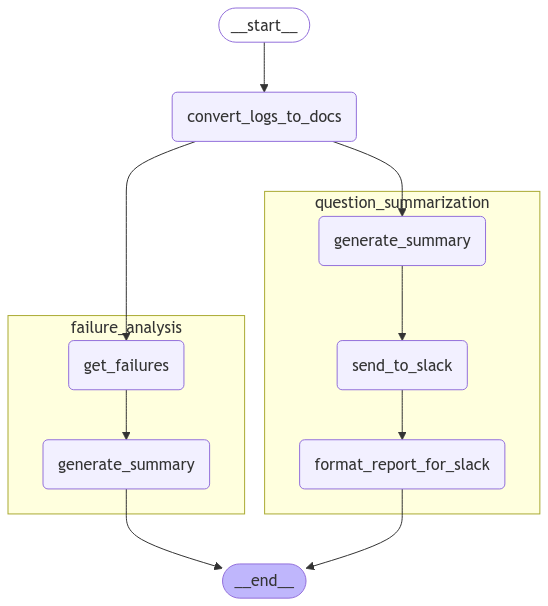

In [48]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [49]:
raw_logs = [{"foo": "bar"}, {"foo": "baz"}]
result = graph.invoke({"raw_logs": raw_logs}, debug=False)

In [50]:

import json

# Prettify JSON
pretty_json = json.dumps(result, indent=4)
print(pretty_json)

{
    "raw_logs": [
        {
            "foo": "bar"
        },
        {
            "foo": "baz"
        }
    ],
    "docs": [
        {
            "id": "1",
            "question": "How can I import ChatOllama?",
            "answer": "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"
        },
        {
            "id": "2",
            "question": "How can I use Chroma vector store?",
            "answer": "To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
            "grade": 0,
            "grader": "Document Relevance Recall",
            "feedback": "The retrieved documents discuss vector stores in general, but not Chroma specifically"
        },
        {
            "id": "1",
            "question": "How can I import ChatOllama?",
            "answer": "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"
        },
        {
            "id": "2",
      

In [51]:

from langchain.chat_models import init_chat_model
import os

# Set the OpenAI API key as an environment variable
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

# Initialize the LLM with single-line init method
model = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)

In [52]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str

# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    # Load subject data from `Send` state object
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

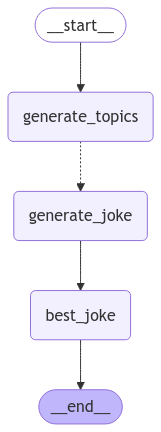

In [53]:
from IPython.display import Image

Image(app.get_graph(xray=1).draw_mermaid_png())

In [ ]:
# Call the graph: here we call it to generate a list of jokes
for chunk in app.stream({"topic": "animals"}):
    print(chunk)